In [2]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from downsample import downsample
%matplotlib inline

In [3]:
pred_json='/home/yiwang/CIVIL-459-Project/predictions/twice_downsampling-300epoch/val-jsons/demo_2/150793954237880600.jpg.predictions.json'
img_path='/work/vita/datasets/OpenDriveLab___OpenLane/raw/images/training/segment-5592790652933523081_667_770_687_770_with_camera_labels/150793954237880600.jpg'
gt_json = '/work/vita/datasets/OpenDriveLab___OpenLane/raw/lane3d_1000/training/segment-5592790652933523081_667_770_687_770_with_camera_labels/150793954237880600.json'
with open(gt_json, 'r') as f:
    openlane_anno = json.load(f)
with open(pred_json, 'r') as f:
    openlane_pred = json.load(f)

In [4]:
def get_xyz_prediction(pred_json, camera_intrinsic, depth_map):
    lane_dicts = []

    with open(pred_json, 'r') as f:
        pred = json.load(f)
    for i, lane_dict in enumerate(pred[:]):
        score = lane_dict["score"]
        # if score < 0.15:
        #     continue
        
        kp_dict = lane_dict["keypoints"] 
        u = np.array(kp_dict[::3])
        v = np.array(kp_dict[1::3])
        # only keep those where u < 1920 and v < 1080
        for k in range(len(u)):
            if u[k] > 1920 or v[k] > 1080:
                u[k] = -1
                v[k] = -1
        u = u[u != -1]
        v = v[v != -1]
        # upsample the keypoint to 100 points
        # u, v = downsample(u, v, 100)
        # get z value from depth_map with u,v 
        # open depth map as numpy array
        np_depth_map = np.loadtxt(depth_map,delimiter=',')  
        z = np.array([np_depth_map[int(v[k]), int(u[k])] for k in range(len(u))])
        # project to 3d
        x = (u - camera_intrinsic[0][2]) * z / camera_intrinsic[0][0]
        y = (v - camera_intrinsic[1][2]) * z / camera_intrinsic[1][1]
        # update the keypoint dict
        lane_dicts.append([x, y, z])

    return lane_dicts
        

        
lane_pred = get_xyz_prediction(pred_json, openlane_anno["intrinsic"], "/home/yiwang/ZoeDepth/pred_depth/fine-tuned_for_demo/150793954237880600.csv")

In [32]:
zs = np.loadtxt("/home/yiwang/ZoeDepth/pred_depth/finetuned_self/150793953957798100.csv", delimiter=',')

In [33]:
np.max(zs)

67.02266693115234

In [25]:
openlane_anno["intrinsic"]

[[2084.604312956009, 0.0, 933.4067577078355],
 [0.0, 2084.604312956009, 665.0223418347507],
 [0.0, 0.0, 1.0]]

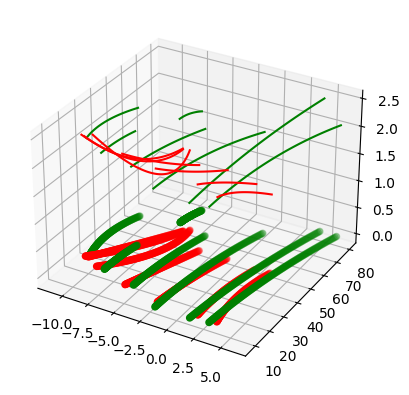

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, lane_dict in enumerate(openlane_anno["lane_lines"][:]):
        
    xyz_dict = lane_dict["xyz"]
    visibility = np.array(lane_dict["visibility"])
    
    x = 0-np.array(xyz_dict[1])
    y = np.array(xyz_dict[0])
    z = 0-np.array(xyz_dict[2])
    # ax.scatter(x, y, z)
    # only keep those where visibility == 1
    x = x[visibility > 0]
    y = y[visibility > 0]
    z = z[visibility > 0]
    close_mask = y < 80
    x = x[close_mask]
    y = y[close_mask]
    z = z[close_mask]
    if len(x) < 2:
        continue
    

    degree = 2  # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="green")
    # cast to x-y plane
    ax.scatter(x_values, y_values, np.zeros(len(x_values)), color="green")

for j in range(len(lane_pred)):
    xyz_dict = lane_pred[j]
    x = np.array(xyz_dict[0])
    y = np.array(xyz_dict[2])
    z = np.array(xyz_dict[1])
    
    degree = 2  # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="red")
    ax.scatter(x_values, y_values, np.zeros(len(x_values)), color="red")

plt.show()



/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


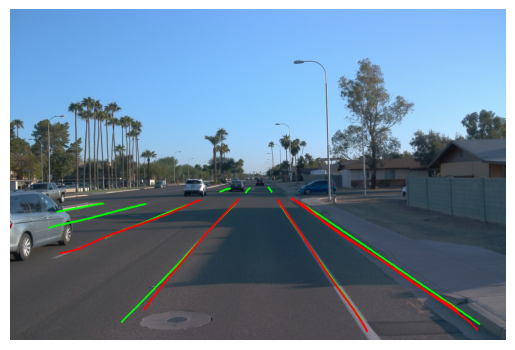

In [6]:
# polynomial fitting for gt
green = (0, 255, 0)
red = (0, 0, 255)
img = cv2.imread(img_path)
img = cv2.resize(img, (1920,1280))
blank_image = np.zeros_like(img)
# show image
plt.imshow(img)
for i, lane_dict in enumerate(openlane_anno["lane_lines"][:]):
        
    uv_dict = lane_dict["uv"]
    
    x = np.round(np.array(uv_dict[0])).astype(int)
    y = np.round(np.array(uv_dict[1])).astype(int)

    new_x, new_y = downsample(x, y, 24)
    new_x, new_y = downsample(new_x, new_y, 24)
    count = len(x)
    # for j, coordinates in enumerate(zip(new_x.astype(int), new_y.astype(int))):
    #     cv2.drawMarker(img, coordinates, color=green, markerType=cv2.MARKER_CROSS, thickness=2,
    #                     markerSize=12)

    polynomial_coefficients = np.polyfit(new_y, new_x, 7) # You can adjust the degree
    polynomial = np.poly1d(polynomial_coefficients)
    # Generate a range of y-values
    y_values = np.linspace(min(new_y), max(new_y), 100)
    # Calculate the corresponding x-values
    x_values = polynomial(y_values).astype(int)

    for j in range(len(y_values) - 1):
        start_point = (x_values[j], int(y_values[j]))
        end_point = (x_values[j + 1], int(y_values[j + 1]))
        cv2.line(img, start_point, end_point, green, 5) # Adjust color and thickness as needed
        
for i, lane_dict in enumerate(openlane_pred[:]):
        
    kp_dict = lane_dict["keypoints"]
    
    x = np.round(np.array(kp_dict[::3])).astype(int)
    y = np.round(np.array(kp_dict[1::3])).astype(int)
    x, y = downsample(x, y, 100)

    
    count = len(x)
    # for j, coordinates in enumerate(zip(new_x.astype(int), new_y.astype(int))):
    #     cv2.drawMarker(img, coordinates, color=green, markerType=cv2.MARKER_CROSS, thickness=2,
    #                     markerSize=12)

    polynomial_coefficients = np.polyfit(y, x, 7) # You can adjust the degree
    polynomial = np.poly1d(polynomial_coefficients)
    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)
    # Calculate the corresponding x-values
    x_values = polynomial(y_values).astype(int)

    for j in range(len(y_values) - 1):
        start_point = (x_values[j], int(y_values[j]))
        end_point = (x_values[j + 1], int(y_values[j + 1]))
        cv2.line(img, start_point, end_point, red, 5) # Adjust color and thickness as needed


result = cv2.addWeighted(img, 1, blank_image, 0, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


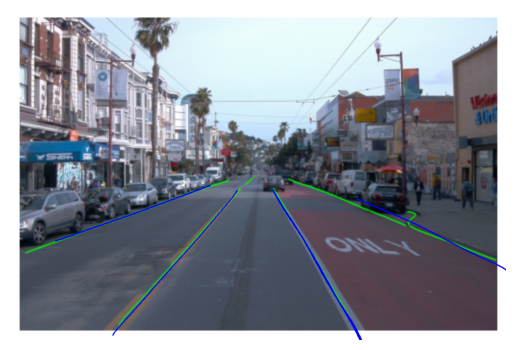

In [39]:
# polynomial fitting of prediction
img = cv2.imread('/home/yiwang/CIVIL-459-Project/gt.png')
img = cv2.resize(img, (1920,1280))
blank_image = np.zeros_like(img)
# show image
plt.imshow(img)
for i, lane_dict in enumerate(openlane_pred[:]):
        
    kp_dict = lane_dict["keypoints"]
    
    x = np.round(np.array(kp_dict[::3])).astype(int)
    y = np.round(np.array(kp_dict[1::3])).astype(int)
    x, y = downsample(x, y, 100)

    
    count = len(x)
    # for j, coordinates in enumerate(zip(new_x.astype(int), new_y.astype(int))):
    #     cv2.drawMarker(img, coordinates, color=green, markerType=cv2.MARKER_CROSS, thickness=2,
    #                     markerSize=12)

    polynomial_coefficients = np.polyfit(y, x, 7) # You can adjust the degree
    polynomial = np.poly1d(polynomial_coefficients)
    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)
    # Calculate the corresponding x-values
    x_values = polynomial(y_values).astype(int)

    for j in range(len(y_values) - 1):
        start_point = (x_values[j], int(y_values[j]))
        end_point = (x_values[j + 1], int(y_values[j + 1]))
        cv2.line(img, start_point, end_point, red, 3) # Adjust color and thickness as needed

result = cv2.addWeighted(img, 1, blank_image, 0, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [2]:
pred_json='/home/yiwang/CIVIL-459-Project/all-images/150767882687643500.jpg.predictions.json'
img_path='/work/vita/datasets/OpenDriveLab___OpenLane/raw/images/training/segment-15832924468527961_1564_160_1584_160_with_camera_labels/150767882687643500.jpg'
gt_json = '/work/vita/datasets/OpenDriveLab___OpenLane/raw/lane3d_1000/training/segment-15832924468527961_1564_160_1584_160_with_camera_labels/150767882687643500.json'
with open(gt_json, 'r') as f:
    openlane_anno = json.load(f)
with open(pred_json, 'r') as f:
    openlane_pred = json.load(f)

In [40]:
##### fix projection matrix ######
def get_xyz_prediction(pred_json, camera_intrinsic, depth_map):
    lane_dicts = []

    with open(pred_json, 'r') as f:
        pred = json.load(f)
    for i, lane_dict in enumerate(pred[:]):
        score = lane_dict["score"]
        # if score < 0.15:
        #     continue
        
        kp_dict = lane_dict["keypoints"] 
        u = np.array(kp_dict[::3])
        v = np.array(kp_dict[1::3])
        # only keep those where u < 1920 and v < 1080
        for k in range(len(u)):
            if u[k] > 1920 or v[k] > 1080:
                u[k] = -1
                v[k] = -1
        u = u[u != -1]
        v = v[v != -1]

        np_depth_map = np.loadtxt(depth_map,delimiter=',')  
        z = np.array([np_depth_map[int(v[k]), int(u[k])] for k in range(len(u))])
        # project to 3d
        inv_intrinsic = np.linalg.inv(camera_intrinsic)
        points_2d_hom = np.vstack((u * z, v * z, z))
        points_3d_cam = np.matmul(inv_intrinsic, points_2d_hom)

        # Now, if you need to apply the camera representation transformation
        # make sure to add the homogeneous coordinate after this transformation.
        # The cam_representation matrix
        cam_representation = np.array([
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [1, 0, 0, 0],
            [0, 0, 0, 1]
        ], dtype=float)

        # Add the homogeneous coordinate for the camera representation transformation
        points_3d_cam_hom = np.vstack((points_3d_cam, np.ones((1, points_3d_cam.shape[1]))))

        # Apply the camera representation transformation
        xyz_world_hom = np.matmul(cam_representation, points_3d_cam_hom)
        x = xyz_world_hom[1, :]
        y = xyz_world_hom[2, :]
        z = xyz_world_hom[0, :]
        # update the keypoint dict
        lane_dicts.append([x, y, z])

    return lane_dicts
        

        
lane_pred = get_xyz_prediction(pred_json, openlane_anno["intrinsic"], "/home/yiwang/ZoeDepth/outputs/3d_reconstruction/150767882687643500.csv")

/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yiwang/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


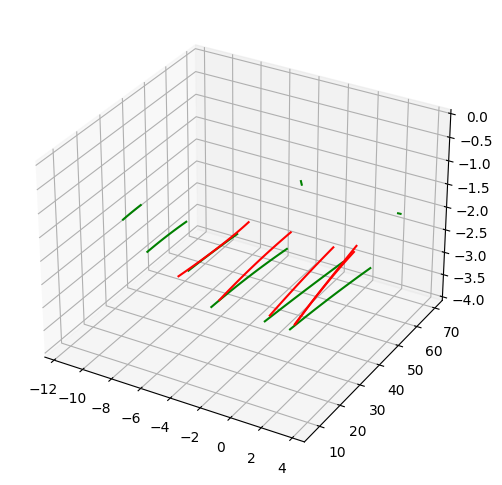

In [14]:
# finetuned_self
fig = plt.figure()
#set figure size
fig.set_size_inches(18, 6)
ax = fig.add_subplot(111, projection='3d')

for i, lane_dict in enumerate(openlane_anno["lane_lines"][:]):
        
    xyz_dict = lane_dict["xyz"]
    visibility = np.array(lane_dict["visibility"])
    
    x =  - np.array(xyz_dict[1])
    y = np.array(xyz_dict[0])
    # y =  np.zeros(len(x))
    z =  np.array(xyz_dict[2])
    # ax.scatter(x, y, z)
    # only keep those where visibility == 1
    x = x[visibility > 0]
    y = y[visibility > 0]
    z = z[visibility > 0]
    close_mask = y < 70
    x = x[close_mask]
    y = y[close_mask]
    z = z[close_mask]
    if len(x) < 2:
        continue

    degree = 2 # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="green")
    # set z limit
    ax.set_zlim(-4.0, 0)
    # cast to x-y plane
    # ax.plot(x_values, y_values, np.zeros(len(x_values)), color="green")
   

for j in range(len(lane_pred)):
    xyz_dict = lane_pred[j]
    x =    np.array(xyz_dict[0])
    y =    np.array(xyz_dict[2])
    z =  - np.array(xyz_dict[1])
    
    degree = 2  # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)
    # print(z_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="red")
    ax.set_zlim(-4.0, 0)
    # ax.plot(x_values, y_values, np.zeros(len(x_values)), color="red")

plt.show()


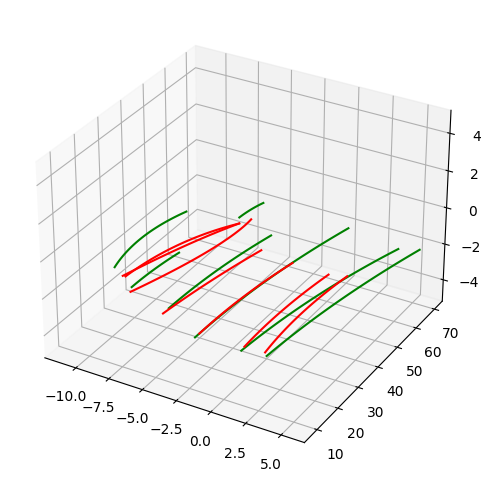

In [69]:
# original
fig = plt.figure()
#set figure size
fig.set_size_inches(18, 6)
ax = fig.add_subplot(111, projection='3d')

for i, lane_dict in enumerate(openlane_anno["lane_lines"][:]):
        
    xyz_dict = lane_dict["xyz"]
    visibility = np.array(lane_dict["visibility"])
    
    x =   - np.array(xyz_dict[1])
    y = np.array(xyz_dict[0])
    # y =  np.zeros(len(x))
    z =  np.array(xyz_dict[2])
    # ax.scatter(x, y, z)
    # only keep those where visibility == 1
    x = x[visibility > 0]
    y = y[visibility > 0]
    z = z[visibility > 0]
    close_mask = y < 70
    x = x[close_mask]
    y = y[close_mask]
    z = z[close_mask]
    if len(x) < 2:
        continue

    degree = 2 # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="green")
    # set z limit
    ax.set_zlim(-5.0, 5)
    # cast to x-y plane
    # ax.plot(x_values, y_values, np.zeros(len(x_values)), color="green")
   

for j in range(len(lane_pred)):
    xyz_dict = lane_pred[j]
    x =     np.array(xyz_dict[0])
    y =    np.array(xyz_dict[2])
    z = - np.array(xyz_dict[1])
    
    degree = 2  # You can adjust the degree of the polynomial
    coefficients_x = np.polyfit(y, x, degree)
    coefficients_z = np.polyfit(y, z, degree)

    # Create a polynomial function from the coefficients
    polynomial_x = np.poly1d(coefficients_x)
    polynomial_z = np.poly1d(coefficients_z)

    # Generate a range of y-values
    y_values = np.linspace(min(y), max(y), 100)

    # Calculate the corresponding x and z values
    x_values = polynomial_x(y_values)
    z_values = polynomial_z(y_values)
    # print(z_values)

    # Plot the polynomial
    ax.plot(x_values, y_values, z_values, color="red")
    ax.set_zlim(-5.0, 5)
    # ax.plot(x_values, y_values, np.zeros(len(x_values)), color="red")

plt.show()
